In [1]:
# import numpy, matplotlib, and other things necessary for simulating a game of battleship
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import matplotlib.cm as cm
from tqdm import tqdm

np.random.seed(298)

In [2]:
# define the ship size
ship_sizes = [(5, 1), (4, 1), (3, 1), (3, 1), (2, 1)]
num_ships = len(ship_sizes)
board_size = 10

# place two random ships on the board
def generate_board(board_size=board_size, num_ships=num_ships, ship_sizes=ship_sizes):
    board = np.zeros((board_size, board_size))
    for i in range(num_ships):
        ship_size = ship_sizes[i]
        if np.random.rand() > 0.5:
            ship_size = ship_size[::-1]
        ship = np.random.randint(0, board_size, 2) # Place ship

        # Check if ship would overlap with existing ships or be adjacent to them
        while (ship[0] + ship_size[0] > board_size or 
            ship[1] + ship_size[1] > board_size or 
            np.any(board[max(0, ship[0]-1):min(board_size, ship[0]+ship_size[0]+1),
                        max(0, ship[1]-1):min(board_size, ship[1]+ship_size[1]+1)] > 0)):
            
            ship = np.random.randint(0, board_size, 2) # Place ship

        board[ship[0]:ship[0]+ship_size[0], ship[1]:ship[1]+ship_size[1]] = 1 # Mark grid as occupied
    
    return board

board = generate_board(board_size, num_ships)

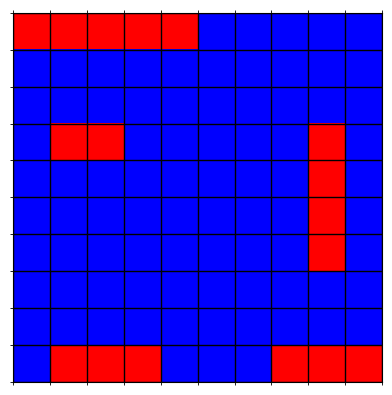

In [3]:
def generate_plot(board, board_size=board_size):
    # create figure and axis
    fig, ax = plt.subplots()

    # create a matrix plot of the board
    cmap = colors.ListedColormap(['blue', 'red'])
    ax.matshow(board, cmap=cmap)

    # put grid lines in plot
    ax.grid(True, which='both', color='black', linewidth=1)

    # Set the ticks to be at the center of each cell
    ax.set_xticks(np.arange(-.5, board_size, 1), minor=True)
    ax.set_yticks(np.arange(-.5, board_size, 1), minor=True)

    # Remove major tick labels
    ax.set_xticks([])
    ax.set_yticks([])

    # Show the plot
    plt.show()

generate_plot(board)

In [4]:
# # generate 10 sample boards
# boards = [generate_board(10, 5) for _ in range(10)]

# # generate plots of the sample boards
# for board in boards:
#     generate_plot(board)

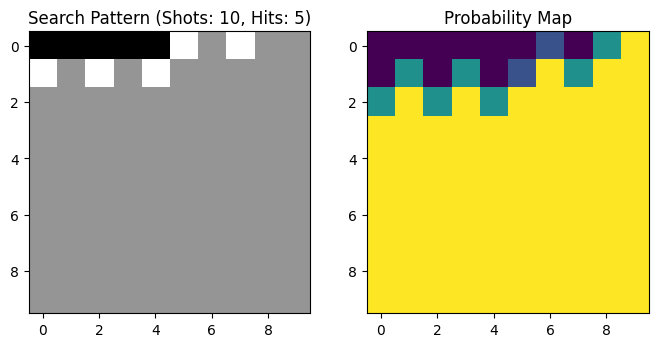

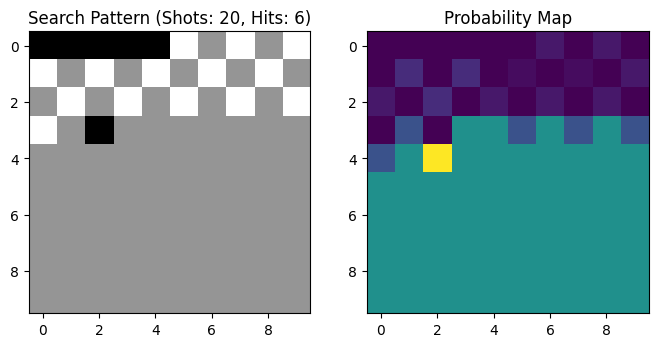

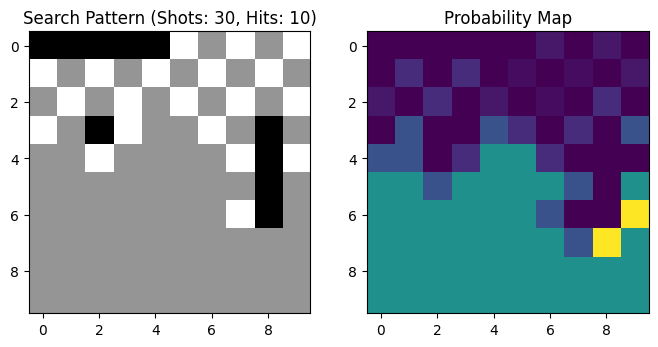

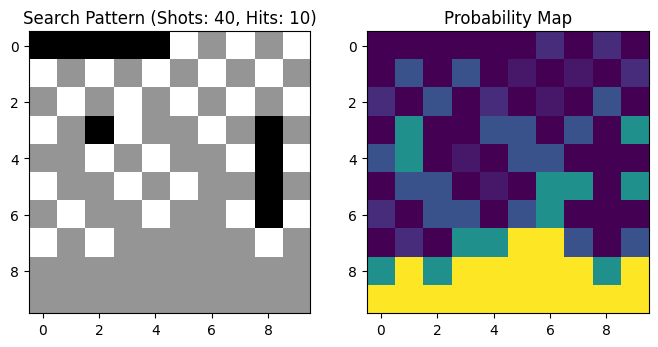

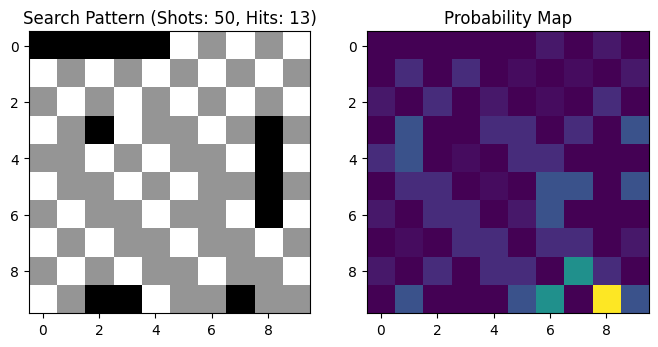

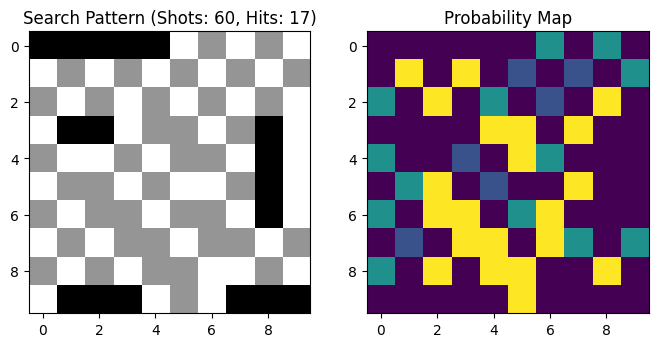

Found all ships in 60 shots


In [5]:
def bayesian_search(board_size=board_size):
    # Initialize probability distribution (uniform prior)
    prob_map = np.ones((board_size, board_size)) / (board_size * board_size)
    
    # Initialize hit map to track shots
    hit_map = np.zeros((board_size, board_size))
    
    # Prior knowledge: ships are more likely to be in lines
    def update_probabilities(prob_map, x, y, hit):
        # Update based on hit or miss
        if hit:
            # If hit, increase probability of adjacent cells
            for dx, dy in [(0,1), (0,-1), (1,0), (-1,0)]:
                new_x, new_y = x + dx, y + dy
                if 0 <= new_x < board_size and 0 <= new_y < board_size and hit_map[new_x, new_y] == 0:
                    prob_map[new_x, new_y] *= 2
        else:
            # If miss, decrease probability of adjacent cells
            for dx, dy in [(0,1), (0,-1), (1,0), (-1,0)]:
                new_x, new_y = x + dx, y + dy
                if 0 <= new_x < board_size and 0 <= new_y < board_size:
                    prob_map[new_x, new_y] *= 0.5
        
        # Normalize probabilities
        prob_map = prob_map / np.sum(prob_map)
        return prob_map
    
    # Simulate search
    shots = 0
    hits = 0
    while hits < np.sum(board):  # Continue until all ships are found
        # Find highest probability location
        x, y = np.unravel_index(np.argmax(prob_map), prob_map.shape)
        
        # Take shot
        hit = board[x, y] == 1
        hit_map[x, y] = 1 if hit else -1
        shots += 1
        
        if hit:
            hits += 1
        
        # Update probabilities
        prob_map[x, y] = 0  # Zero out probability of searched location
        prob_map = update_probabilities(prob_map, x, y, hit)
        
        # Visualize current state (optional)
        if shots % 10 == 0:  # Show every 10 shots
            plt.figure(figsize=(8, 4))
            
            plt.subplot(121)
            plt.imshow(hit_map, cmap='Greys')
            plt.title(f'Search Pattern (Shots: {shots}, Hits: {hits})')
            
            plt.subplot(122)
            plt.imshow(prob_map, cmap='viridis')
            plt.title('Probability Map')
            
            plt.show()
    
    return shots, hit_map

# Run the search
shots, final_pattern = bayesian_search()
print(f"Found all ships in {shots} shots")